## Explainer for Signal

The explainer is also made for SAP Signavio Analytics Language, a query language made for performing process mining tasks on large amount of event data.

First, import the necessary modules.

In [1]:
import sys
sys.path.append('../')
from explainer.explainer_util import Trace
from explainer.explainer_signal import ExplainerSignal

## Initilize the explainer

The signal explainer is developed to be a proof of concept, hence the code is highly tailored to be used on the selected data set. With access to more API calls and conformance queries, that do not need a data set, the explainer could be developed for a broader usage.

In [2]:
exp = ExplainerSignal()
exp.set_endpoint('/g/api/pi-graphql/signal') #Load the data set

# Let's add some constrainst, these are taken from the tutorial in bpmnconstraints module

exp.add_constraint("(^NOT('review request'|'prepare contract')*('review request'~>'prepare contract')*NOT('review request'|'prepare contract')*$)")
exp.add_constraint("(^NOT('prepare contract')* ('prepare contract' ANY*'send quote')* NOT('prepare contract')*$)")
exp.add_constraint("(^NOT('assess risks')* ('assess risks' ANY*'send quote')* NOT('assess risks')*$)")

### Minimal possible trace violation

The same fashion as ExplainerRegex.

In [3]:
trace = Trace(['credit requested', 'review request', 'prepare special terms', 'assess risks', 'prepare special terms', 'prepare contract', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent'])
print(trace.nodes)
print("---------------------")
print(exp.minimal_expl(trace))


['credit requested', 'review request', 'prepare special terms', 'assess risks', 'prepare special terms', 'prepare contract', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
---------------------
Non-conformance due to: Constraint ((^NOT('assess risks')* ('assess risks' ANY*'send quote')* NOT('assess risks')*$)) is violated by subtrace: ('credit requested', 'review request')


### Counterfactuals

Also, similar to ExplainerRegex.

In [4]:
print(exp.counterfactual_expl(trace))


Addition (Added review request at position 0): review request->credit requested->review request->prepare special terms->assess risks->prepare special terms->prepare contract->assess risks->prepare contract->send quote->send quote->quote sent


## Contribution functions

We'll start with conformance rate and fitness rate, given some arbritary constraints.

In [5]:
conf_rate = exp.determine_conformance_rate()
fit_rate = exp.determine_fitness_rate()
print("Conformance rate: " + str(conf_rate))
print("Fitness rate    : " + str(fit_rate))

Conformance rate: 0.71
Fitness rate    : 0.8933333333333333


`variant_ctrb_to_conformance_loss` determines how much a specific variant contributes to the overall conformance loss.

This is done slightly different when working with a data set, because all variations have to be considered

In [6]:
total_contribution = 0
i = 0
for trace in exp.event_log.get_traces():
    i +=1
    ctrb = exp.variant_ctrb_to_conformance_loss(
        event_log=exp.event_log,
        trace=trace,
    )
    total_contribution += ctrb
    # Let's just show some traces
    if i % 10 == 0:
        print(f"Contribution is: {ctrb}, for trace {trace.nodes}")
print(f"Total distribution to the conformance loss is {total_contribution}")
print(f"Our total conformance loss is {1 - conf_rate}")


Contribution is: 0.0, for trace ['review request', 'calculate terms', 'credit requested', 'calculate terms', 'assess risks', 'prepare contract', 'review request', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.0, for trace ['credit requested', 'review request', 'review request', 'prepare contract', 'assess risks', 'calculate terms', 'assess risks', 'calculate terms', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.0, for trace ['credit requested', 'calculate terms', 'review request', 'review request', 'assess risks', 'calculate terms', 'prepare contract', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.0, for trace ['credit requested', 'review request', 'review request', 'assess risks', 'assess risks', 'calculate terms', 'prepare contract', 'calculate terms', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.01, for trace ['s

`variant_ctrb_to_fitness` determines how much a specific variant contributes to the overall fitness rate.

This is also done in the same way

In [7]:
total_contribution = 0
i = 0
for trace in exp.event_log.get_traces():
    i +=1
    ctrb = exp.variant_ctrb_to_fitness(
        event_log=exp.event_log,
        trace=trace,
    )
    total_contribution += ctrb
    # Let's just show some traces
    if i % 10 == 0:
        print(f"Contribution is: {ctrb}, for trace {trace.nodes}")
print(f"Total distribution to the fitness is: {total_contribution}")
print(f"Our total fitness rate loss is:       {1 - fit_rate}")

Contribution is: 0.0, for trace ['review request', 'calculate terms', 'credit requested', 'calculate terms', 'assess risks', 'prepare contract', 'review request', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.0, for trace ['credit requested', 'review request', 'review request', 'prepare contract', 'assess risks', 'calculate terms', 'assess risks', 'calculate terms', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.0, for trace ['credit requested', 'calculate terms', 'review request', 'review request', 'assess risks', 'calculate terms', 'prepare contract', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.0, for trace ['credit requested', 'review request', 'review request', 'assess risks', 'assess risks', 'calculate terms', 'prepare contract', 'calculate terms', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.00333333333333333

`constraint_ctrb_to_fitness` determines how much a specific constraint contributes to the overall fitness rate

In [8]:
ctrb_0 = exp.constraint_ctrb_to_fitness(exp.event_log, exp.constraints, 0)
ctrb_1 = exp.constraint_ctrb_to_fitness(exp.event_log, exp.constraints, 1)
ctrb_2 = exp.constraint_ctrb_to_fitness(exp.event_log, exp.constraints, 2)

print(f"Contribution is: {ctrb_0}, for constrainst {exp.constraints[0]}")
print(f"Contribution is: {ctrb_1}, for constrainst {exp.constraints[1]}")
print(f"Contribution is: {ctrb_2}, for constrainst {exp.constraints[2]}")

print(f"Our total contribution to the fitness rate is: {ctrb_0 + ctrb_1 + ctrb_2}")
print(f"Compared to our fitness rate loss            : {1 - fit_rate}")

Contribution is: 0.06666666666666667, for constrainst (^NOT('review request'|'prepare contract')*('review request'~>'prepare contract')*NOT('review request'|'prepare contract')*$)
Contribution is: 0.016666666666666666, for constrainst (^NOT('prepare contract')* ('prepare contract' ANY*'send quote')* NOT('prepare contract')*$)
Contribution is: 0.023333333333333334, for constrainst (^NOT('assess risks')* ('assess risks' ANY*'send quote')* NOT('assess risks')*$)
Our total contribution to the fitness rate is: 0.10666666666666666
Compared to our fitness rate loss            : 0.10666666666666669


## Shapley values

`constraint_ctrb_to_conformance` determines how much a specific constraint contributes to the overall conformance loss. 

Because the constraints overlap in this case, Shapley values have been used to determine the contribution. This makes the method more complicated and more computationally heavy than the other contribution functions 


In [9]:
ctrb_0 = exp.constraint_ctrb_to_conformance(exp.event_log, exp.constraints, 0)
ctrb_1 = exp.constraint_ctrb_to_conformance(exp.event_log, exp.constraints, 1)
ctrb_2 = exp.constraint_ctrb_to_conformance(exp.event_log, exp.constraints, 2)

print(f"Contribution is: {ctrb_0}, for constrainst {exp.constraints[0]}")
print(f"Contribution is: {ctrb_1}, for constrainst {exp.constraints[1]}")
print(f"Contribution is: {ctrb_2}, for constrainst {exp.constraints[2]}")

print(f"Our total contribution to the conformance loss is: {ctrb_0 + ctrb_1 + ctrb_2}")
print(f"Compared to our conformance loss                 : {1 - conf_rate}")

Contribution is: 0.19, for constrainst (^NOT('review request'|'prepare contract')*('review request'~>'prepare contract')*NOT('review request'|'prepare contract')*$)
Contribution is: 0.040000000000000036, for constrainst (^NOT('prepare contract')* ('prepare contract' ANY*'send quote')* NOT('prepare contract')*$)
Contribution is: 0.06, for constrainst (^NOT('assess risks')* ('assess risks' ANY*'send quote')* NOT('assess risks')*$)
Our total contribution to the conformance loss is: 0.29000000000000004
Compared to our conformance loss                 : 0.29000000000000004


## Combining BPMN2CONSTRAINTS and the Explainer

By using code from the bpmnconstraints tutorial, one can extract the constraints from a diagram and apply the explainer to that data set

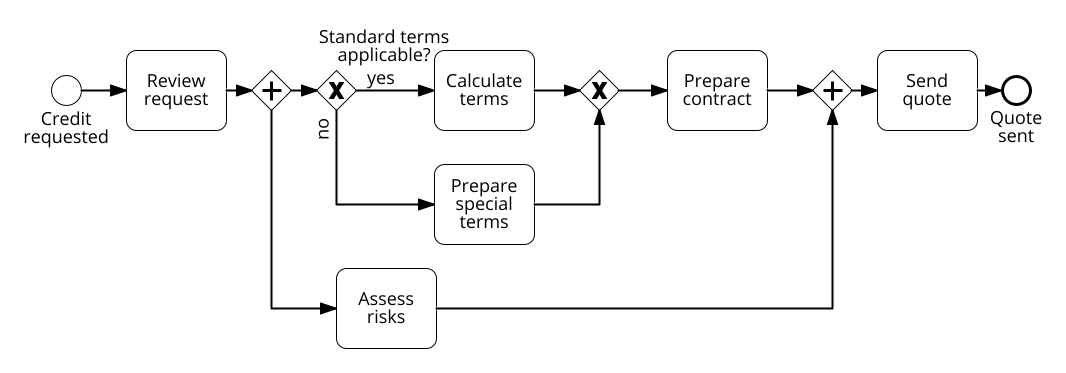

In [10]:
import sys
sys.path.append("../../")

from bpmnconstraints.script import compile_bpmn_diagram
import SignavioAuthenticator
import requests
from IPython.display import Image, display
import json
import logging
from conf import *
logging.getLogger("urllib3").setLevel(logging.WARNING)

system_instance = 'https://editor.signavio.com'
workspace_id = workspace_id# workspace id
user_name = user_name# username
pw = pw # pw
revision_id = '1fe7397c17304d3ba4ea41f1eefc97fe'
authenticator = SignavioAuthenticator.SignavioAuthenticator(system_instance, workspace_id, user_name, pw)
auth_data = authenticator.authenticate()
cookies = {'JSESSIONID': auth_data['jsesssion_ID'], 'LBROUTEID': auth_data['lb_route_ID']}
headers = {'Accept': 'application/json', 'x-signavio-id':  auth_data['auth_token']}
diagram_url = system_instance + '/p/revision'

json_request = requests.get(
    f'{diagram_url}/{revision_id}/json',
    cookies=cookies,
    headers=headers)
json_diagram = json_request.content
path = './diagram.json'
with open(path, 'w') as f:
    json.dump(json.loads(json_diagram), f)
png_request = requests.get(
    f'{diagram_url}/{revision_id}/png',
    cookies=cookies,
    headers=headers)
display(Image(png_request.content))

These are the constraints generated from the diagram

In [11]:
signal_constraints = compile_bpmn_diagram(path, "SIGNAL", False)
signal_constraints = list(set(signal_constraints))
print(signal_constraints)
print("The amount of constraints: " + str(len(signal_constraints)))


INFO:root:Generating SIGNAL constraints...


100%|██████████| 119/119 [00:00<?, ?it/s]

["(^NOT('calculate terms')* ('calculate terms' ANY*'prepare contract')* NOT('calculate terms')*$)", "( ^ NOT('prepare special terms'|'send quote')* ('prepare special terms'NOT('prepare special terms'|'send quote')*'send quote'NOT('prepare special terms'|'send quote')*)*NOT('prepare special terms'|'send quote')* $)", "(^NOT('assess risks')*('review request' NOT('assess risks')*'assess risks'NOT('assess risks')*)*NOT('assess risks')*$)", "(^ (NOT 'review request' | ('review request' (NOT 'review request')* 'prepare special terms'))*$)", "(^NOT('review request'|'prepare contract')*(('review request'ANY*'prepare contract'ANY*)|('prepare contract'ANY* 'review request' ANY*))* NOT('review request'|'prepare contract')*$)", "(^NOT('calculate terms'|'send quote')*('calculate terms'~>'send quote')*NOT('calculate terms'|'send quote')*$)", "(^NOT('calculate terms'|'prepare contract')*(('calculate terms'ANY*'prepare contract'ANY*)|('prepare contract'ANY* 'calculate terms' ANY*))* NOT('calculate ter

Now we can use the explainer with the data set and the constraints


In [12]:
exp = ExplainerSignal() #Reset the explainer
exp.set_endpoint('/g/api/pi-graphql/signal')
for con in signal_constraints:
    exp.add_constraint(con)
    
conf_rate = exp.determine_conformance_rate()
fit_rate = exp.determine_fitness_rate()
print("Conformance rate: " + str(conf_rate))
print("Fitness rate    : " + str(fit_rate))

Conformance rate: 0.0
Fitness rate    : 0.4780392156862745


`variant_ctrb_to_conformance_loss`

In [13]:
total_contribution = 0
i = 0
for trace in exp.event_log.get_traces():
    i +=1
    ctrb = exp.variant_ctrb_to_conformance_loss(
        event_log=exp.event_log,
        trace=trace,
    )
    total_contribution += ctrb
    # Let's just show some traces
    if i % 10 == 0:
        print(f"Contribution is: {ctrb}, for trace {trace.nodes}")
print(f"Total distribution to the conformance loss is {total_contribution}")
print(f"Our total conformance loss is {1 - conf_rate}")

Contribution is: 0.01, for trace ['review request', 'calculate terms', 'credit requested', 'calculate terms', 'assess risks', 'prepare contract', 'review request', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.01, for trace ['credit requested', 'review request', 'review request', 'prepare contract', 'assess risks', 'calculate terms', 'assess risks', 'calculate terms', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.02, for trace ['credit requested', 'calculate terms', 'review request', 'review request', 'assess risks', 'calculate terms', 'prepare contract', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.01, for trace ['credit requested', 'review request', 'review request', 'assess risks', 'assess risks', 'calculate terms', 'prepare contract', 'calculate terms', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.01, for trace

`variant_ctrb_to_fitness`

In [14]:
total_contribution = 0
i = 0
for trace in exp.event_log.get_traces():
    i +=1
    ctrb = exp.variant_ctrb_to_fitness(
        event_log=exp.event_log,
        trace=trace,
    )
    total_contribution += ctrb
    # Let's just show some traces
    if i % 10 == 0:
        print(f"Contribution is: {ctrb}, for trace {trace.nodes}")
print(f"Total distribution to the fitness is {total_contribution}")
print(f"Our total fitness rate loss is {1 - fit_rate}")

Contribution is: 0.004313725490196079, for trace ['review request', 'calculate terms', 'credit requested', 'calculate terms', 'assess risks', 'prepare contract', 'review request', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.005294117647058823, for trace ['credit requested', 'review request', 'review request', 'prepare contract', 'assess risks', 'calculate terms', 'assess risks', 'calculate terms', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.010196078431372548, for trace ['credit requested', 'calculate terms', 'review request', 'review request', 'assess risks', 'calculate terms', 'prepare contract', 'assess risks', 'prepare contract', 'send quote', 'send quote', 'quote sent']
Contribution is: 0.004705882352941176, for trace ['credit requested', 'review request', 'review request', 'assess risks', 'assess risks', 'calculate terms', 'prepare contract', 'calculate terms', 'prepare contract', 'send quot

`constraint_ctrb_to_fitness`

In [15]:
total_contribution = 0
i = 0
for con in signal_constraints:
    ctrb = exp.constraint_ctrb_to_fitness(
        log=exp.event_log,
        constraints=exp.constraints,
        index=i
    )
    i +=1
    total_contribution += ctrb
    # Let's just show some traces
    if i % 10 == 0:
        print(f"Contribution is: {ctrb}, for constraint {con}")
        
print(f"Total distribution to the fitness is {total_contribution}")
print(f"Our total fitness rate loss is {1 - fit_rate}")

Contribution is: 0.000980392156862745, for constraint (^NOT('prepare contract')* ('prepare contract' ANY*'send quote')* NOT('prepare contract')*$)
Contribution is: 0.019215686274509803, for constraint ( ^ NOT('review request'|'prepare contract')* ('review request'NOT('review request'|'prepare contract')*'prepare contract'NOT('review request'|'prepare contract')*)*NOT('review request'|'prepare contract')* $)
Contribution is: 0.01588235294117647, for constraint (^NOT('prepare special terms'|'send quote')*('prepare special terms'~>'send quote')*NOT('prepare special terms'|'send quote')*$)
Contribution is: 0.019019607843137255, for constraint ('send quote'$)
Contribution is: 0.0, for constraint (('prepare contract'|'send quote'))
Total distribution to the fitness is 0.5219607843137255
Our total fitness rate loss is 0.5219607843137255


`constraint_ctrb_to_conformance`

This does not seem to work currently, my suspicion is that the amount of constraints crashes the computer when applying the computationally heavy Shapley values to it 

In [16]:

"""
total_contribution = 0
i = 0
for con in signal_constraints:
    ctrb = exp.constraint_ctrb_to_conformance(
        log=exp.event_log,
        constraints=exp.constraints,
        index=i
    )
    i +=1
    total_contribution += ctrb
    # Let's just show some traces
    if i % 10 == 0:
        print(f"Contribution is: {ctrb}, for constraint {con}")
        
print(f"Total distribution to the conformance loss is {total_contribution}")
print(f"Our total conformance loss is { 1 - conf_rate}")
"""

'\ntotal_contribution = 0\ni = 0\nfor con in signal_constraints:\n    ctrb = exp.constraint_ctrb_to_conformance(\n        log=exp.event_log,\n        constraints=exp.constraints,\n        index=i\n    )\n    i +=1\n    total_contribution += ctrb\n    # Let\'s just show some traces\n    if i % 10 == 0:\n        print(f"Contribution is: {ctrb}, for constraint {con}")\n        \nprint(f"Total distribution to the conformance loss is {total_contribution}")\nprint(f"Our total conformance loss is { 1 - conf_rate}")\n'